In [1]:
from surprise import Dataset, Reader, KNNWithMeans
from surprise.model_selection import cross_validate, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from surprise import accuracy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Title: LiveRec

### Description: 
Our datasets have been collected from Twitch. We took a full snapshot of all availble streams every 10 minutes, during 43 days. For each stream, we retrieved all logged in users from the chat. Start and stop times are provided as integers and represent periods of 10 minutes.

### Fields description:
- user_id: user identifier (anonymized).
- stream id: stream identifier, could be used to retreive a single broadcast segment (not used in our study).
    streamer name: name of the channel.
- start time: first crawling round at which the user was seen in the chat (e.g. if a user's start time is recorded as "10", it means that the user was first seen in the chat during the 10th crawling round)
- stop time: last crawling round at which the user was seen in the chat (e.g. if a user's stop time is recorded as "20", it means that the user was last seen in the chat during the 20th crawling round)

In [2]:
file_path = "100k_a.csv"
column_names = ['user_id', 'stream_id', 'streamer_name', 'start_time', 'stop_time']
df = pd.read_csv(file_path, names=column_names)
df

,user_id,stream_id,streamer_name,start_time,stop_time
0,1,33842865744,mithrain,154,156
1,1,33846768288,alptv,166,169
2,1,33886469056,mithrain,587,588
3,1,33887624992,wtcn,589,591
4,1,33890145056,jrokezftw,591,594
...,...,...,...,...,...
3051728,100000,34167930576,mckytv,3582,3583
3051729,100000,34168288656,natehill,3582,3583
3051730,100000,34169594512,fortnite,3582,3584
3051731,100000,34180223072,highdistortion,3709,3711


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3051733 entries, 0 to 3051732
Data columns (total 5 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int64 
 1   stream_id      int64 
 2   streamer_name  object
 3   start_time     int64 
 4   stop_time      int64 
dtypes: int64(4), object(1)
memory usage: 116.4+ MB


### My rating calculation:
- Я буду рекомендувати юзеру стрімера, в залежності від того, скільки часу юзер провів на стрімах стрімера
- Рейтинг буде від 1 до 10

In [4]:
df['time_spent'] = df['stop_time'] - df['start_time']

avg_time_df = df.groupby(['user_id', 'streamer_name'])['time_spent'].mean().reset_index()
user_min_max = avg_time_df.groupby('user_id')['time_spent'].agg(['min', 'max']).reset_index()

avg_time_df = pd.merge(avg_time_df, user_min_max, on='user_id', suffixes=('', '_max'))

avg_time_df['rating'] = 1 + 9 * ((avg_time_df['time_spent'] - avg_time_df['min']) / (avg_time_df['max'] - avg_time_df['min']))
avg_time_df.dropna(subset=['rating'], inplace=True)
avg_time_df.drop(['min', 'max'], axis=1, inplace=True)

df_1 = avg_time_df.sort_values(by='rating', ascending=False)

In [47]:
zero_values_exist = (df['time_spent'] == 0).any()
zero_values_exist

False

In [5]:
num_unique_users = df_1['user_id'].nunique()
num_unique_streamers = df_1['streamer_name'].nunique()

print("Number of unique users:", num_unique_users)
print("Number of unique streamers:", num_unique_streamers)

Number of unique users: 95331
Number of unique streamers: 160460


In [6]:
rating_counts = df_1['rating'].value_counts()
rating_counts 

rating
1.000000     685924
10.000000    112359
5.500000      30729
3.250000      25353
4.000000      24870
              ...  
3.053571          1
3.053050          1
3.052809          1
3.052632          1
9.981092          1
Name: count, Length: 21142, dtype: int64

### Centered Knn
Значення ознак кожного об'єкта з датасету центрується навколо середнього значення цієї ознаки.

In [7]:
reader = Reader(rating_scale=(1, 10))

chunk_size = 10000
num_chunks = len(df_1) // chunk_size + 1

results = []
rmse_values = []
mae_values = []


for chunk_id in range(num_chunks):
    start_idx = chunk_id * chunk_size
    end_idx = min((chunk_id + 1) * chunk_size, len(df_1))
    
    chunk_df = df_1[['user_id', 'streamer_name', 'rating']].iloc[start_idx:end_idx]
    
    data_chunk = Dataset.load_from_df(chunk_df, reader)
    
    sim_options = {'name': 'cosine', 'user_based': True}
    knn_algo = KNNWithMeans(k=50, sim_options=sim_options)
    
    chunk_results = cross_validate(knn_algo, data_chunk, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    results.append(chunk_results)
    
    avg_rmse = sum(chunk_results['test_rmse']) / len(chunk_results['test_rmse'])
    avg_mae = sum(chunk_results['test_mae']) / len(chunk_results['test_mae'])
    
    rmse_values.append(avg_rmse)
    mae_values.append(avg_mae)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [8]:
overall_avg_rmse = sum(rmse_values) / len(rmse_values)
overall_avg_mae = sum(mae_values) / len(mae_values)

print("Overall Average RMSE:", overall_avg_rmse)
print("Overall Average MAE:", overall_avg_mae)

Overall Average RMSE: 0.01788000781433853
Overall Average MAE: 0.0141053185442191


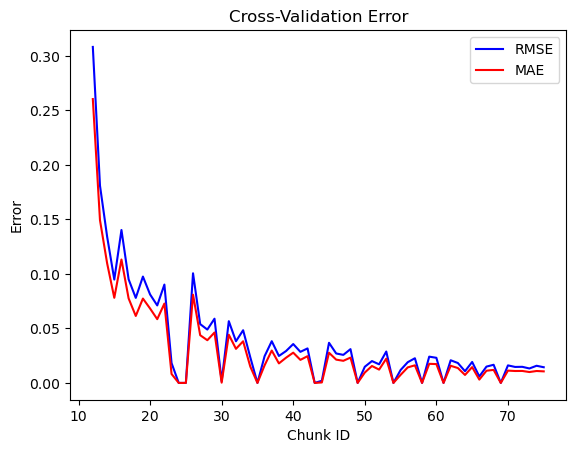

In [75]:
plt.plot(range(12, min(num_chunks + 1, 76)), rmse_values[11:75],  color='b', label='RMSE')
plt.plot(range(12, min(num_chunks + 1, 76)), mae_values[11:75],  color='r', label='MAE')
plt.xlabel('Chunk ID')
plt.ylabel('Error')
plt.legend()
plt.title('Cross-Validation Error')
plt.show()

In [28]:
reader = Reader(rating_scale=(1, 10))

chunk_size = 10000
num_chunks = len(df_1) // chunk_size + 1
all_predictions = {}

for chunk_id in range(num_chunks):
    start_idx = chunk_id * chunk_size
    end_idx = min((chunk_id + 1) * chunk_size, len(df_1))
    
    chunk_df = df_1[['user_id', 'streamer_name', 'rating']].iloc[start_idx:end_idx]
    data_chunk = Dataset.load_from_df(chunk_df, reader)
    
    sim_options = {'name': 'cosine', 'user_based': True}
    knn_algo = KNNWithMeans(k=50, sim_options=sim_options)
    trainset, testset = train_test_split(data_chunk, test_size=0.2)
    knn_algo.fit(trainset)
    
    predictions = knn_algo.test(testset)
    
    for pred in predictions:
        user_id = pred.uid
        streamer_name = pred.iid
        if user_id not in all_predictions:
            all_predictions[user_id] = {}
        all_predictions[user_id][streamer_name] = {
            'Actual Rating': pred.r_ui,
            'Predicted Rating': pred.est
        }

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [29]:
actual_ratings = []
predicted_ratings = []

for user_id, user_ratings in all_predictions.items():
    for streamer_name, ratings in user_ratings.items():
        actual_ratings.append(ratings['Actual Rating'])
        predicted_ratings.append(ratings['Predicted Rating'])

mae = mean_absolute_error(actual_ratings, predicted_ratings)
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))

print("-----Training---- \n")
print("MAE:", mae)
print("RMSE:", rmse)
print("\n-----Cross-validation---- \n")
print("Overall Average RMSE:", overall_avg_rmse)
print("Overall Average MAE:", overall_avg_mae)

-----Training---- 

MAE: 0.017307536685369013
RMSE: 0.13155811143889612

-----Cross-validation---- 

Overall Average RMSE: 0.01788000781433853
Overall Average MAE: 0.0141053185442191


In [33]:
# Convert the dictionary to a DataFrame
all_predictions_df = pd.DataFrame.from_dict(
    {(user_id, streamer_name): values for user_id, user_predictions in all_predictions.items() for streamer_name, values in user_predictions.items()},
    orient='index'
)

all_predictions_df.reset_index(inplace=True)
all_predictions_df.rename(columns={'level_0': 'user_id', 'level_1': 'streamer_name'}, inplace=True)

In [31]:
merged_df = pd.merge(all_predictions_df, df_1, on=['user_id', 'streamer_name'], how='inner')
all_predictions_df['Actual Rating'] = merged_df['rating']

all_predictions_df['Absolute Difference'] = abs(all_predictions_df['Actual Rating'] - all_predictions_df['Predicted Rating'])
sorted_df = all_predictions_df.sort_values(by='Absolute Difference', ascending=False)

worst_pred_df = sorted_df.head(10)
best_pred_df = sorted_df.tail(10)

### Top Worst predictions

In [14]:
worst_pred_df

,user_id,streamer_name,Actual Rating,Predicted Rating,Absolute Difference
87105,96225,amouranth,10.000000,9.100000,0.900000
82443,85289,gratis150ml,10.000000,9.100000,0.900000
87553,23317,mizkif,9.181818,10.000000,0.818182
86650,51040,akariss,9.868035,9.129032,0.739003
82385,85501,gorgc,10.000000,9.265306,0.734694
84943,23343,shroud,9.307692,10.000000,0.692308
82318,32538,venruki,10.000000,9.307692,0.692308
81925,5597,cherrypach,9.181818,9.863636,0.681818
81926,5597,sah_yang,9.181818,9.863636,0.681818
83811,23483,alanzoka,9.859375,9.179688,0.679687


### Top Best predictions

In [15]:
best_pred_df

,user_id,streamer_name,Actual Rating,Predicted Rating,Absolute Difference
113314,54061,giannielee,1.0,1.0,0.0
113315,54061,jdnerdtv,1.0,1.0,0.0
113317,9048,nervarien,1.0,1.0,0.0
113318,9048,kittyplays,1.0,1.0,0.0
113319,9048,shroud,1.0,1.0,0.0
113327,86830,randomweather,1.0,1.0,0.0
113329,49868,gotaga,1.0,1.0,0.0
113331,74256,macke0ne,5.5,5.5,0.0
113333,74256,annitheduck,1.0,1.0,0.0
296575,54880,2kboo,1.0,1.0,0.0


In [32]:
wrong_predictions = (all_predictions_df['Absolute Difference'] != 0.0)
percentage_wrong = (wrong_predictions.sum() / len(all_predictions_df)) * 100

print("\nNumber of incorect predictions: ", wrong_predictions.sum())
print("Number of correct predictions: ", len(all_predictions_df)-wrong_predictions.sum())

print("\nPercentage of incorrect predictions: {:.2f}%".format(percentage_wrong))
print("Percentage of correct predictions: {:.2f}%".format(100 - percentage_wrong))


Number of incorect predictions:  128780
Number of correct predictions:  167796

Percentage of incorrect predictions: 43.42%
Percentage of correct predictions: 56.58%


### Trying to improve accuracy

In [18]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'k': [20, 30, 40, 50],  
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True],
        'centered': [True, False], 
        'reg': [0.01, 0.02, 0.05]
    },
    'min_k': [1, 5, 10],
    'max_k': [100, 200, 300]
}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)
chunk_size = 10000
num_chunks = len(df_1) // chunk_size + 1

for chunk_id in range(num_chunks):
    start_idx = chunk_id * chunk_size
    end_idx = min((chunk_id + 1) * chunk_size, len(df_1))
    
    chunk_df = df_1[['user_id', 'streamer_name', 'rating']].iloc[start_idx:end_idx]
    data_chunk = Dataset.load_from_df(chunk_df, reader)
    
    trainset, testset = train_test_split(data_chunk, test_size=0.2)
    gs.fit(data_chunk)
     
   # print("Chunk", chunk_id)
   # print("Best RMSE score:", gs.best_score['rmse'])
   # print("Best MAE score:", gs.best_score['mae'])
   # print("Best parameters:", gs.best_params['rmse'])
   # print()


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

KeyboardInterrupt: 

In [57]:
reader = Reader(rating_scale=(1, 10))
chunk_size = 10000
num_chunks = len(df_1) // chunk_size + 1

rmse_values = []
mae_values = []
all_predictions = {}

for chunk_id in range(num_chunks):
    start_idx = chunk_id * chunk_size
    end_idx = min((chunk_id + 1) * chunk_size, len(df_1))
    
    chunk_df = df_1[['user_id', 'streamer_name', 'rating']].iloc[start_idx:end_idx]
    data_chunk = Dataset.load_from_df(chunk_df, reader)                 
    sim_options = {'name': 'cosine', 'user_based': True, 'centered': True, 'reg': 0.01, 'min_k': 10,
    'max_k': 100}
    knn_algo = KNNWithMeans(k=30, sim_options=sim_options)
    
    #CV
    cv_results = cross_validate(knn_algo, data_chunk, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    
    avg_rmse = np.mean(cv_results['test_rmse'])
    avg_mae = np.mean(cv_results['test_mae'])
    
    rmse_values.append(avg_rmse)
    mae_values.append(avg_mae)
    
    # Train
    trainset, testset = train_test_split(data_chunk, test_size=0.2)
    knn_algo.fit(trainset)
    
    predictions = knn_algo.test(testset)
    
    for pred in predictions:
        user_id = pred.uid
        streamer_name = pred.iid
        if user_id not in all_predictions:
            all_predictions[user_id] = {}
        all_predictions[user_id][streamer_name] = {
            'Actual Rating': chunk_df.loc[(chunk_df['user_id'] == user_id) & (chunk_df['streamer_name'] == streamer_name), 'rating'].iloc[0],
            'Predicted Rating': pred.est
        }

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [76]:
all_predictions_df = pd.DataFrame.from_dict(
    {(user_id, streamer_name): values for user_id, user_predictions in all_predictions.items() for streamer_name, values in user_predictions.items()},
    orient='index'
)

all_predictions_df.reset_index(inplace=True)
all_predictions_df.rename(columns={'level_0': 'user_id', 'level_1': 'streamer_name'}, inplace=True)
merged_df = pd.merge(all_predictions_df, df_1, on=['user_id', 'streamer_name'], how='inner')
all_predictions_df['Actual Rating'] = merged_df['rating']

all_predictions_df['Absolute Difference'] = abs(all_predictions_df['Actual Rating'] - all_predictions_df['Predicted Rating'])
sorted_df = all_predictions_df.sort_values(by='Absolute Difference', ascending=False)

wrong_predictions = (all_predictions_df['Absolute Difference'] != 0.0)
percentage_wrong = (wrong_predictions.sum() / len(all_predictions_df)) * 100

overall_rmse = sum(rmse_values) / len(rmse_values)
overall_mae = sum(mae_values) / len(mae_values)

print("\nNumber of incorect predictions: ", wrong_predictions.sum())
print("Number of correct predictions: ", len(all_predictions_df)-wrong_predictions.sum())

print("\nPercentage of incorrect predictions: {:.2f}%".format(percentage_wrong))
print("Percentage of correct predictions: {:.2f}%".format(100 - percentage_wrong))


Number of incorect predictions:  97438
Number of correct predictions:  199138

Percentage of incorrect predictions: 32.85%
Percentage of correct predictions: 67.15%


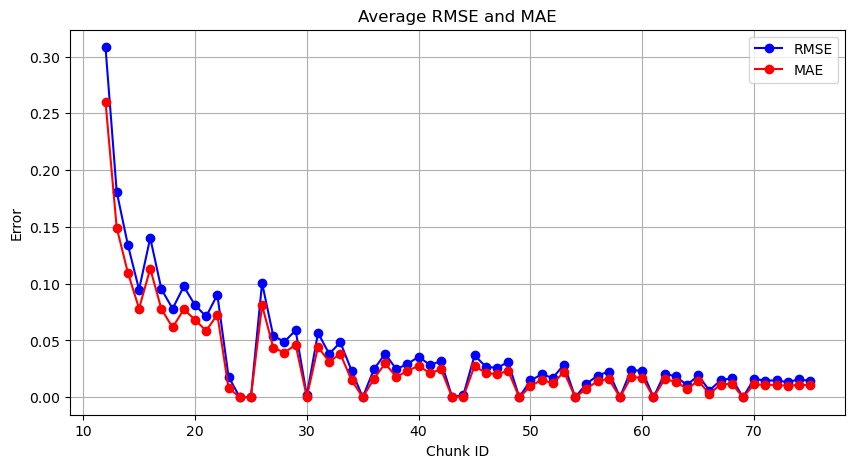

In [74]:
plt.figure(figsize=(10, 5))
plt.plot(range(12, min(num_chunks + 1, 76)), rmse_values[11:75], marker='o', color='b', label='RMSE')
plt.plot(range(12, min(num_chunks + 1, 76)), mae_values[11:75], marker='o', color='r', label='MAE')
plt.xlabel('Chunk ID')
plt.ylabel('Error')
plt.title('Average RMSE and MAE')
plt.legend()
plt.grid(True)
plt.show()

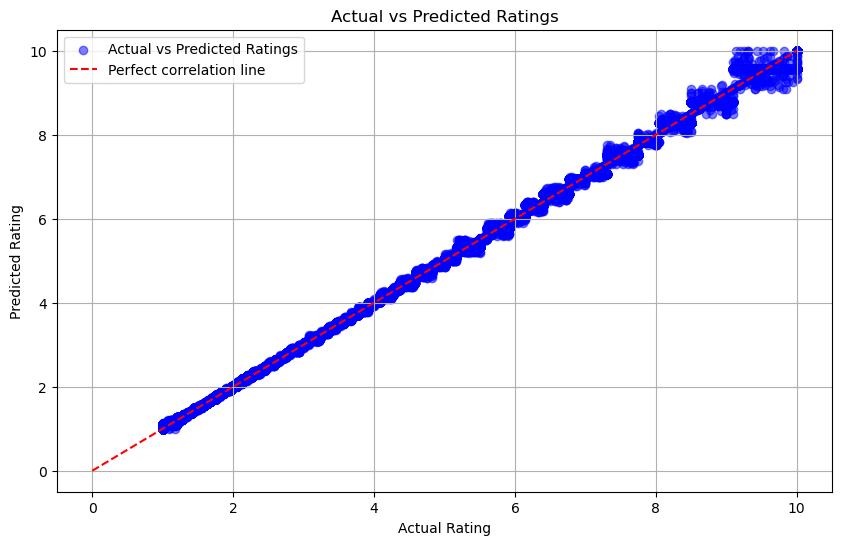

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(all_predictions_df['Actual Rating'], all_predictions_df['Predicted Rating'], color='blue', label='Actual vs Predicted Ratings', alpha=0.5)
plt.plot([0, 10], [0, 10], color='red', linestyle='--', label='Perfect correlation line')
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.legend()
plt.grid(True)
plt.show()

### Порівняння з SVD (UΣV^T)

In [48]:
from surprise import SVD
reader = Reader(rating_scale=(1, 10))

data = Dataset.load_from_df(df_1[['user_id', 'streamer_name', 'rating']], reader)
algo = SVD()
cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

avg_rmse = sum(cv_results['test_rmse']) / len(cv_results['test_rmse'])
avg_mae = sum(cv_results['test_mae']) / len(cv_results['test_mae'])

rmse_values = [avg_rmse] * num_chunks
mae_values = [avg_mae] * num_chunks

In [49]:
print("Average RMSE:", avg_rmse)
print("Average MAE:", avg_mae)

Average RMSE: 2.772201455199557
Average MAE: 2.0792393412754855


### Random rating with RMSE, MAE

In [59]:
from surprise.prediction_algorithms.random_pred import NormalPredictor

reader = Reader(rating_scale=(1, 10))

random_ratings = np.random.uniform(1, 10, len(df_1))
rmse_rand = np.sqrt(np.mean((df_1['rating'] - random_ratings) ** 2))
mae_rand = np.mean(np.abs(df_1['rating'] - random_ratings))

print("RMSE between actual ratings and random values:", rmse_rand)
print("MAE between actual ratings and random values:", mae_rand)

RMSE between actual ratings and random values: 4.5929202617975795
MAE between actual ratings and random values: 3.843035264913414


### Mean rating with RMSE, MAE

In [60]:
mean_rating = df_1['rating'].mean()

mean_ratings = np.full_like(df_1['rating'], mean_rating)

rmse_mean = np.sqrt(np.mean((df_1['rating'] - mean_ratings) ** 2))
mae_mean = np.mean(np.abs(df_1['rating'] - mean_ratings))

print("RMSE between actual ratings and mean values:", rmse_mean)
print("MAE between actual ratings and mean values:", mae_mean)

RMSE between actual ratings and mean values: 2.748301216893579
MAE between actual ratings and mean values: 2.1315679370810217


### Median rating with RMSE, MAE

In [61]:
median_rating = df_1['rating'].median()
median_ratings = np.full_like(df_1['rating'], median_rating)
rmse_med = np.sqrt(np.mean((df_1['rating'] - median_ratings) ** 2))
mae_med = np.mean(np.abs(df_1['rating'] - median_ratings))

print("RMSE between actual ratings and median values:", rmse_med)
print("MAE between actual ratings and median values:", mae_med)

RMSE between actual ratings and median values: 3.0793449041392758
MAE between actual ratings and median values: 1.8634450771618705


In [66]:
print("RMSE random values:", rmse_rand)
print("MAE random values:", mae_rand)

print("\nRMSE mean values:", rmse_mean)
print("MAE mean values:", mae_mean)

print("\nRMSE median values:", rmse_med)
print("MAE median values:", mae_med)

print("\nNORMAL RMSE:", overall_rmse)
print("NORMAL MAE:", overall_mae)

RMSE random values: 4.5929202617975795
MAE random values: 3.843035264913414

RMSE mean values: 2.748301216893579
MAE mean values: 2.1315679370810217

RMSE median values: 3.0793449041392758
MAE median values: 1.8634450771618705

NORMAL RMSE: 0.017872199416195625
NORMAL MAE: 0.01409797110413815
